<a href="https://colab.research.google.com/github/freealise/freealise/blob/main/opencv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ffmpy
import IPython.display as display
from ffmpy import FFmpeg
ff = FFmpeg(
    inputs={'movie.mp4': None },
    outputs={'output.png': '-f apng -vf "chromakey=0xffffff:0.01:0.2"' }
)
ff.run()
ff = FFmpeg(
    inputs={'output.png': None},
    outputs={'output.gif': None}
)
ff.run()
video="output.gif"
display.display(display.Markdown(F"""![]({video})"""))

![](output.gif)

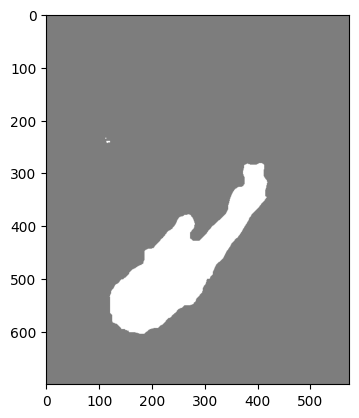

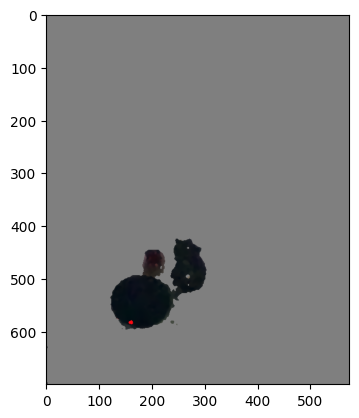

In [41]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

cap = cv.VideoCapture(cv.samples.findFile("IMG_0111_.mp4"))
i=0
ret = True
frames = []
frame = None
while(1):
  ret, frame = cap.read()
  if not ret:
    break
  else:
    frames.append(cv.cvtColor(frame, cv.COLOR_BGR2RGB))

n = 25
indx = 0 #has to be the sharpest frame
half = int(n/2)
if indx-half < 0:
  n = indx*2+1
elif indx+half >= len(frames):
  n = (len(frames)-1-indx)*2+1

#denoise
frame = cv.fastNlMeansDenoisingColoredMulti(
    srcImgs = frames,
    imgToDenoiseIndex = indx,
    temporalWindowSize = n,
    hColor = 5,
    templateWindowSize = 21,
    searchWindowSize = 21)

b = 5
#subtract background (get scene with shadow) and correct hue against light
bg = cv.medianBlur(frame, 255)
bg_gray = cv.cvtColor(cv.cvtColor(bg, cv.COLOR_RGB2GRAY), cv.COLOR_GRAY2RGB)
bg_diff = (bg-bg_gray).astype(np.int16)
frame_ = ((bg.astype(np.int16)-frame.astype(np.int16))+127).astype(np.uint8)
frame = (frame.astype(np.int16)-bg_diff).astype(np.uint8)
frame_ = cv.bilateralFilter(frame_, b*4, b*8, b*2)

#remove regions of low saturation (get scene without shadow)
mask = cv.cvtColor(frame, cv.COLOR_RGB2HSV)
m = cv.inRange(mask, np.array([0,0,0]), np.array([180,32,256]))
frame[m>0] = (127,127,127)
frame_ = cv.medianBlur(frame_, b)
element = cv.getStructuringElement(cv.MORPH_RECT, (2*b+1, 2*b+1), (b,b))
frame_ = cv.erode(cv.dilate(frame_, element), element)
frame = cv.medianBlur(frame, b)


m_ = frame_.reshape((-1,3))
# convert to np.float32
m_ = np.float32(m_)
# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 16, 1.0)
K = 3
ret,label,center=cv.kmeans(m_,K,None,criteria,16,cv.KMEANS_PP_CENTERS)
# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
frame_ = res.reshape((frame_.shape))


#remove shadows at edges
cv.rectangle(frame_,(0,0),(frame_.shape[1]-1,frame_.shape[0]-1),(142,142,142),7)
mask = cv.floodFill(frame_, None, (0, 0), 255, 0, 0, (4 | cv.FLOODFILL_FIXED_RANGE))[2] #(4 | cv2.FLOODFILL_FIXED_RANGE | cv2.FLOODFILL_MASK_ONLY | 255 << 8)
    # 255 << 8 tells to fill with the value 255)
mask = mask[1:mask.shape[0]-1, 1:mask.shape[1]-1]
frame_[mask>0] = (125,125,125)
frame_[frame_[:,:,0]>=142] = (255,255,255)

plt.imshow(frame_)
plt.show()
plt.imshow(frame)
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')